In [1]:
%load_ext autoreload
%autoreload 2 


In [22]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os

In [3]:
from models import GazeEstimation_ResNet18

# Configuraciones

Configuraciones para CUDA

In [4]:
# Configuraciones para CUDA
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [5]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device a utilizar:",device)

Device a utilizar: cuda


# Analisis de datos

In [6]:
from datasets import MPIIFaceGaze


In [29]:

ds = MPIIFaceGaze("./datasets/MPIIFaceGaze.h5",10)
print(f"Se cargaron {len(ds)} imagenes")

Dataset cargado correctamente de /home/idk/git/ceia/vpc2_project/datasets/MPIIFaceGaze.h5
Se cargaron 150 imagenes


In [34]:
ds[20]

(array([[[ 23,  21,  23],
         [ 24,  22,  24],
         [ 26,  22,  24],
         ...,
         [ 18,  13,  10],
         [ 18,  13,  11],
         [ 19,  13,  11]],
 
        [[ 23,  22,  22],
         [ 24,  22,  22],
         [ 26,  22,  23],
         ...,
         [ 19,  12,  11],
         [ 20,  13,  12],
         [ 20,  12,  11]],
 
        [[ 24,  22,  22],
         [ 24,  22,  23],
         [ 26,  22,  23],
         ...,
         [ 19,  13,  12],
         [ 21,  12,  13],
         [ 22,  12,  12]],
 
        ...,
 
        [[203, 142,  21],
         [195, 141,  25],
         [188, 139,  26],
         ...,
         [ 66,  51,   8],
         [ 64,  50,   8],
         [ 63,  49,   9]],
 
        [[200, 140,  21],
         [192, 140,  28],
         [187, 140,  30],
         ...,
         [ 66,  51,   8],
         [ 64,  50,   8],
         [ 63,  49,   8]],
 
        [[195, 136,  22],
         [190, 139,  30],
         [188, 141,  35],
         ...,
         [ 67,  51,   8],
  

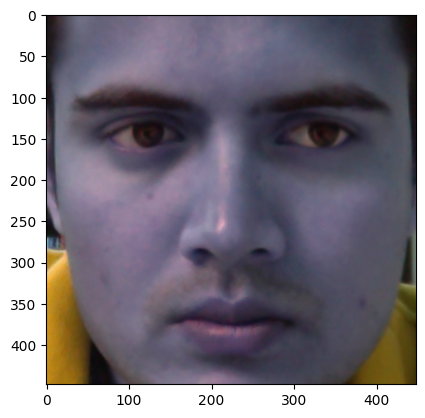

In [35]:
plt.imshow(ds.images_list[20])

# Entrenamiento

Instanciación del modelo y prueba de dimensiones

In [ ]:
# Instanciación del model
model = GazeEstimation_ResNet18(pretrained=True)

# Al ser un problema de regresión se usa MSELoss
criterion = nn.MSELoss()

# Optimizador: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Example forward pass with random input
inputs = torch.randn(8, 3, 224, 224)  # Batch of 8 images, 3 channels (RGB), 224x224 resolution
outputs = model(inputs)  # Outputs will be the predicted yaw and pitch angles

print(outputs)


tensor([[-0.1643, -0.4331],
        [-0.0708, -0.9827],
        [ 0.2841, -0.3811],
        [ 0.2513, -1.1464],
        [ 0.1125, -0.2364],
        [-0.4562, -0.5506],
        [ 0.6596, -0.4931],
        [ 0.1852, -0.9698]], grad_fn=<AddmmBackward0>)


Dataloader

In [ ]:
train_loader = DataLoader(...)  # Your training dataset
val_loader = DataLoader(...)    # Your validation dataset

Entrenamiento propiamente dicho

In [ ]:
model.fit(train_loader, val_loader, criterion, optimizer, epochs=10, device=device)